# Import

In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
import seaborn as sns
import itertools
import warnings
import torch
import transformers as ppb
import string
import matplotlib.pyplot as plt
import joblib
import logging
import inflect

from pprint import pprint as pp
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from tqdm import tqdm_notebook, trange
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from transformers import (glue_convert_examples_to_features, glue_output_modes,
glue_processors)
from multiprocessing import Pool, cpu_count
#import tools 
#import convert_examples_to_features
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows

logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


warnings.simplefilter("ignore", DeprecationWarning)


# Functions

In [50]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()


def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):

    scores_mean = cv_results['mean_test_score']

    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']

    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores

    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)

    for idx, val in enumerate(grid_param_2):

        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')

    ax.set_xlabel(name_param_1, fontsize=16)

    ax.set_ylabel('CV Average Score', fontsize=16)

    ax.legend(loc="best", fontsize=15)

    ax.grid('on')
p = inflect.engine() 

def cv(data):
    
    count_vectorizer = CountVectorizer()
    
    emp = count_vectorizer.fit_transform(data)
    
    return emp, count_vectorizer
# convert number into words 
def convert_number(text): 
    # split string into list of words 
    temp_str = text.split() 
    # initialise empty list 
    new_string = [] 
    
    for word in temp_str: 
        # if word is a digit, convert the digit 
        # to numbers and append into the new_string list 
        if word.isdigit(): 
            temp = p.number_to_words(word) 
            new_string.append(temp) 
  # append the word as it is 
        else: 
            new_string.append(word) 
# join the words of new_string to form a string 
    temp_str = ' '.join(new_string) 
    return temp_str 
  

def standardize_text(df, text_field):
    """ Function for cleaning text"""
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9()!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"'", "")
    df[text_field] = df[text_field].str.replace(r"!", "") 
    df[text_field] = df[text_field].str.lower()
    return df


def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    plt.grid(None)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="black" if cm[i, j] < thresh else "red", fontsize=50)
    
   # plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

def converttostr(input_seq, seperator):
    final_str = seperator.join(input_seq)   
    return final_str

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
def cv(data):
    
    count_vectorizer = CountVectorizer()
    
    emp = count_vectorizer.fit_transform(data)
    
    return emp, count_vectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


def remove_stopwords(text): 
    stop_words = set(stopwords.words("english")) 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return filtered_text 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
lemmatizer = WordNetLemmatizer() 
# lemmatize string 
def lemmatize_word(text): 
    word_tokens = word_tokenize(text) 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return lemmas 
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Neutral', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
#https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
def get_most_important_features(vectorizer, model, n = 5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    #Loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes
def word_feats(words):
        return dict([(word, True) for word in words])



# Import data

In [3]:
df = pd.read_csv('black_news_sent.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

df.Sentiment[df.Sentiment == 'Negative'] = 0
df.Sentiment[df.Sentiment == 'Neutral'] = 1
df.Sentiment[df.Sentiment == 'Positive'] = 2

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


sent = df.Sentiment

tokenizer = nltk.RegexpTokenizer(r"\w+") #Creat tokenizer
df = standardize_text(df, 'newtitle') #remove punctuation and lower case

title = standardize_text(df, 'newtitle') #remove punctuation and lower case

title = title.newtitle #grab titles
ntitle = title.apply(convert_number) #Convert digits to alpha numbers

words = [w for w in ntitle if not w in ntitle]
words = pd.Series(words)
new_words = words.apply(tokenizer.tokenize) #Tokenize
stop_words = set(stopwords.words('english')) #Filter stop words

not_stopwords = {"don't",'when','between', 'under','all','against', 'not'} 
new_stopwords_list = stop_words.union(stop_words)


final_stop_words = set([word for word in new_stopwords_list if word not in not_stopwords])

filtered_titles = {}
for i, s in enumerate(new_words):
    filtered_titles[i]= []
    for x in s:
        if x not in final_stop_words:
            filtered_titles[i].append(x)
        else:
            continue


cats = df.cat



In [4]:
df = pd.read_csv('black_news_sent.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

df.Sentiment[df.Sentiment == 'Negative'] = 0
df.Sentiment[df.Sentiment == 'Neutral'] = 1
df.Sentiment[df.Sentiment == 'Positive'] = 2

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

count_vect = CountVectorizer(stop_words=final_stop_words,)
X_train_counts = count_vect.fit_transform(df.newtitle)
X_train_counts.shape
count_vect.vocabulary_.get(u'algorithm')
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(2856, 5825)

In [5]:
count_vect.vocabulary_.get(u'algorithm')
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(2856, 5825)

In [6]:
tf = TfidfVectorizer(max_features=5900, ngram_range=(1,2)).fit(df.newtitle)
tf.vocabulary_.__len__()  # returns 5945 as we passed 5945 words
tf.fit_transform(df.newtitle)  #

<2856x5900 sparse matrix of type '<class 'numpy.float64'>'
	with 43345 stored elements in Compressed Sparse Row format>

In [7]:
tf.vocabulary_

{'dangerous': 1360,
 'around': 446,
 'world': 5835,
 'police': 3882,
 'around world': 449,
 'it': 2683,
 'been': 634,
 'hectic': 2341,
 'americans': 269,
 'struggle': 4771,
 'as': 461,
 'unemployment': 5439,
 'spikes': 4665,
 'it been': 2684,
 'been hectic': 635,
 'hectic americans': 2342,
 'americans struggle': 277,
 'struggle as': 4772,
 'as unemployment': 488,
 'unemployment spikes': 5440,
 'people': 3810,
 'just': 2781,
 'don': 1572,
 'want': 5623,
 'to': 5115,
 'be': 603,
 'killed': 2820,
 'anti': 381,
 'leader': 2913,
 'on': 3594,
 'protests': 4054,
 'want to': 5625,
 'to be': 5123,
 'leader on': 2914,
 'on protests': 3629,
 'the': 4936,
 'last': 2884,
 'dance': 1357,
 '10': 1,
 'and': 306,
 'social': 4609,
 'media': 3170,
 'the last': 4972,
 'last dance': 2885,
 'and social': 344,
 'social media': 4612,
 'this': 5055,
 'was': 5642,
 'not': 3433,
 'an': 300,
 'isolated': 2678,
 'incident': 2573,
 'biden': 674,
 'compares': 1188,
 'death': 1383,
 'of': 3479,
 'george': 2146,
 'flo

In [8]:

tdf = pd.DataFrame([filtered_titles]).transpose()
tdf.rename(columns={0:'x'}, inplace= True)
tdf['y'] = sent
tdf['cat']=cats
art_words = tdf['x']
art_words

0       [dangerous, around, world, police, chokeholds,...
1       [hectic, americans, struggle, unemployment, sp...
2       [hectic, americans, struggle, unemployment, sp...
3       [people, dont, want, killed, period, anti, apa...
4       [last, dance, episodes, nine, ten, recap, soci...
                              ...                        
2851    [pain, pain, global, anti, racism, protests, r...
2852    [zimbabwe, summons, us, ambassador, national, ...
2853    [zimbabwe, summons, us, envoy, george, floyd, ...
2854    [zuckerberg, cheap, labor, group, defend, blac...
2855    [zuckerberg, facebook, leaving, trumps, shooti...
Name: x, Length: 2856, dtype: object

# Hyper-Parameter tuning/model selection-Cat

In [16]:
newcorpus = art_words.apply(lambda x: converttostr(x, seperator= ' '))
list_corpus = newcorpus.tolist() 

label1=df['cat']
label2 =  [0 if x == 'biz' else 1 if x == 'gen' else 2 for x in label1]




X_train, X_test, y_train_cat, y_test_cat = train_test_split(df.newtitle, label2, 
                                                    test_size=0.2,
                                                    random_state=7274)


In [198]:
sgparameters = {
     'tfidf__use_idf': (True, False),
     'clf__penalty':('l2', 'l1', 'elasticnet'),
     'vect__ngram_range': [(1, 1), (1, 2), (1,3), (1,4), (1,5)],
     'vect__max_features':(None, 5900, 5000, 4500, 4000, 3500),
     'clf__alpha': (1, 1e-2, 1e-3, 1e-4),
     'clf__max_iter':(400, 500, 800, 900, 1000, 1200, 1500)
}
sgd_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=final_stop_words, )),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=32))
    ])
sgd = GridSearchCV(sgd_clf, sgparameters, cv=5, verbose = 2, n_jobs=-1, scoring='precision_weighted')


In [ ]:
# rfparameters = {
#      'tfidf__use_idf': (True, False),
#      'clf__n_estimators': (200, 400, 600, 800),
#      'clf__min_samples_split':(1.0, 2,5,10),
#      'clf__min_samples_leaf':(2,3,4,5,6),
#      'vect__ngram_range': [(1, 1), (1, 2), (1,3), (1,4), (1,5)],
#      'vect__max_features':(None, 5900, 5000, 4500, 4000, 3500),
#      'clf__max_features': ('auto', 'sqrt'),
#      'clf__max_depth':(10,50,100 ),
#      'clf__bootstrap':(False, True)
# }
# rf_clf = Pipeline([
#     ('vect', CountVectorizer(stop_words=final_stop_words, )),
#     ('tfidf', TfidfTransformer()),
#     ('clf', RandomForestClassifier(random_state=32))
#     ])
# rf = GridSearchCV(rf_clf, rfparameters, cv=5, n_jobs=-1, verbose= 2,scoring='precision_micro')


In [199]:

mnbparameters = {
     'tfidf__use_idf': (True, False),
     'vect__ngram_range': [(1, 1), (1, 2), (1,3), (1,4), (1,5)],
     'vect__max_features':(None, 5900, 5000, 4500, 4000, 3500),
     'mnb__alpha': np.linspace(0.5, 1.5, 6),
     'mnb__fit_prior': [True, False],
}
mn_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=final_stop_words, )),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())
    ])
mn = GridSearchCV(mn_clf, mnbparameters, cv=5, verbose = 2, n_jobs=-1, scoring='precision_weighted')


In [200]:
sgd = sgd.fit(X_train,y_train_cat)

Fitting 5 folds for each of 5040 candidates, totalling 25200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

In [ ]:
#rf = rf.fit(X_train,y_train_cat)

In [201]:
mn = mn.fit(X_train, y_train_cat)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1109 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 1554 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 2081 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2688 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3377 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  1.8min finished


In [203]:
sgc = sgd.best_estimator_
#rfc = rf.best_estimator_
mnc = mn.best_estimator_

In [218]:
filename = 'sgc.sav'
pickle.dump(sgc, open(filename, 'wb'))
# filename = 'rfc.sav'
# pickle.dump(rfc, open(filename, 'wb'))
filename = 'mnc.sav'
pickle.dump(mnc, open(filename, 'wb'))


In [ ]:
sns.set_context("poster", font_scale=1.3)
#fig, ax = plt.subplots(figsize=(15, 8))
all_words = [word for tokens in art_words for word in words]
title_lengths = [len(tokens) for tokens in art_words]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max title length is %s" % max(title_lengths))
fig = plt.figure(figsize = (15,8))
plt.xlabel('Headline length')
plt.ylabel('Number of headlines')
plt.hist(title_lengths);
plt.savefig('dist_headlines.png')

In [ ]:
title_length = [len(x) for x in new_words]
len(title_length)

C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


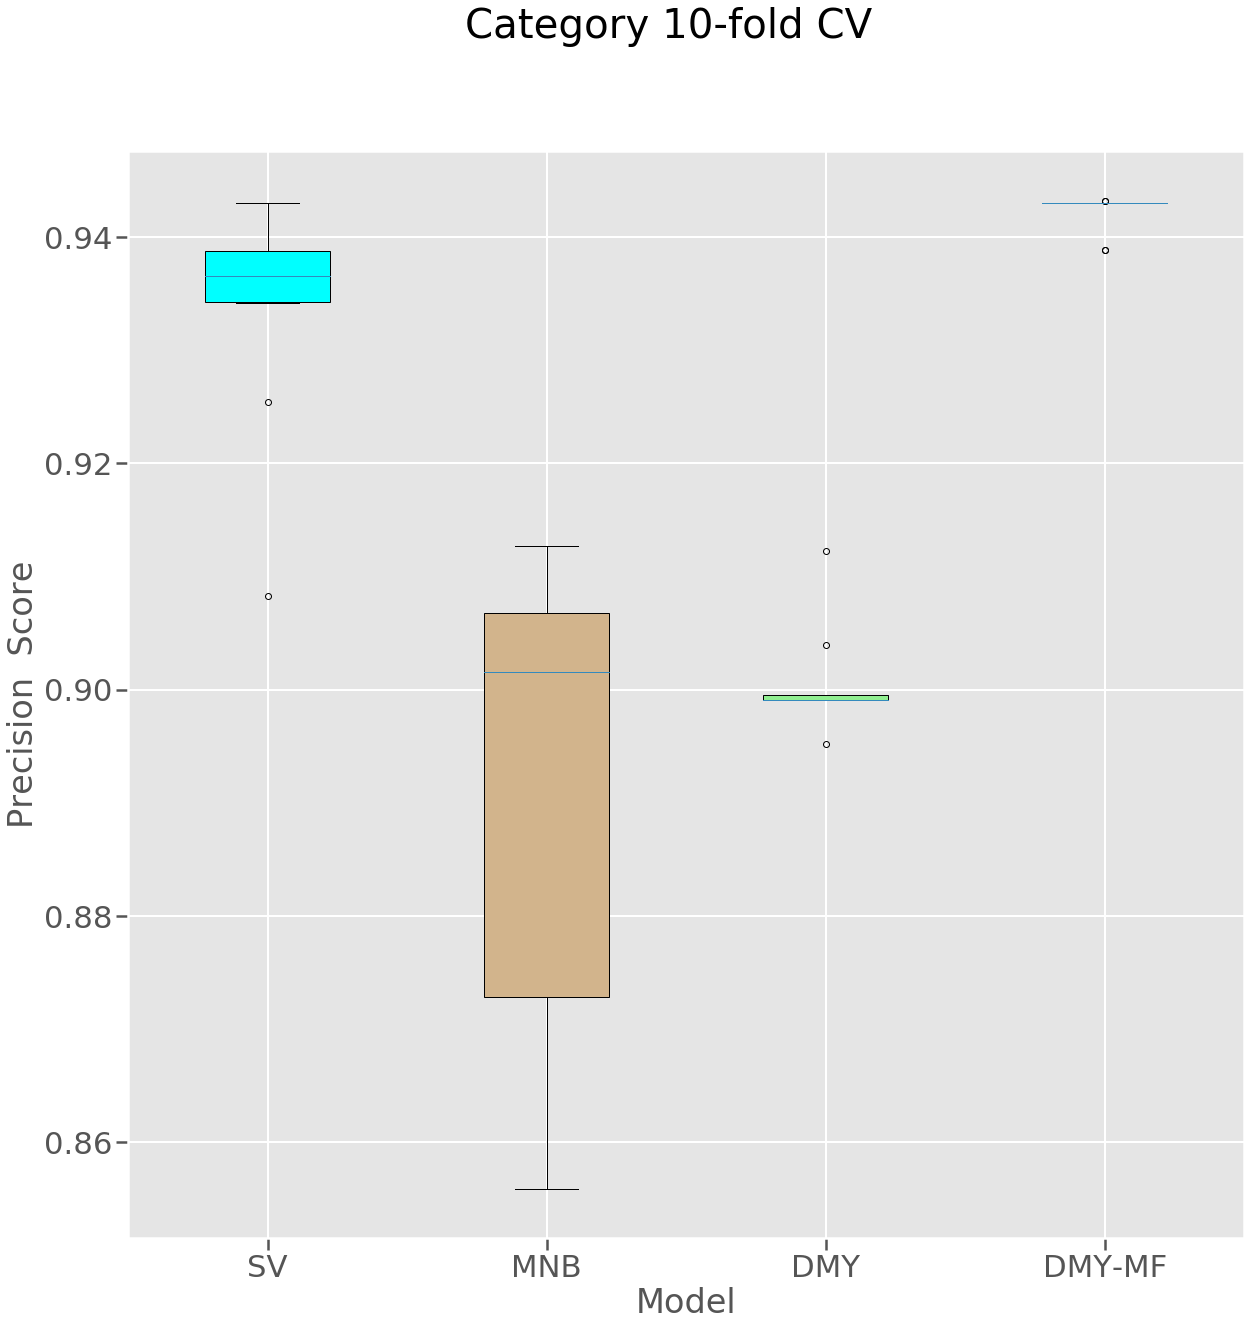

In [219]:
mbcv = model_selection.cross_val_score(mnc,X_train,y_train_cat,
                                        scoring = 'precision_micro',cv = 10
                                         )

# rfcv = model_selection.cross_val_score(rfc,X_train,y_train_cat,
#                                         scoring = 'precision_micro', cv = 10
#                                          )

svcv = model_selection.cross_val_score(sgc,X_train,y_train_cat,
                                        scoring = 'precision_micro', cv = 10
                                         )
#Dummy classifier
dummy_mf = DummyClassifier(strategy="most_frequent", random_state=231)
dummy_mf.fit(X_train, y_train_sent)
dummy = DummyClassifier(random_state=231)
dummy.fit(X_train, y_train_sent)
dummymfcv = model_selection.cross_val_score(dummy_mf,X_train,y_train_cat,
                                        scoring = 'precision_micro',cv=10
                                         )
dummymfcv

dummycv = model_selection.cross_val_score(dummy,X_train,y_train_cat,
                                        scoring = 'precision_micro', cv=10
                                         )

results = [svcv, mbcv , dummycv, dummymfcv ]


plt.style.use('ggplot')

sns.set_context("poster", font_scale=1.4)
fig = plt.figure(figsize=(20,20))
fig.suptitle('Category 10-fold CV')
ax = fig.add_subplot(111)
box = plt.boxplot(results, patch_artist=True)
plt.xlabel('Model')
plt.ylabel('Precision  Score')
ax.set_xticklabels(['SV',  'MNB', 'DMY', 'DMY-MF'])
colors = ['cyan',  'tan', 'lightgreen', 'pink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.savefig('class_comparison_cat.png')
plt.show()

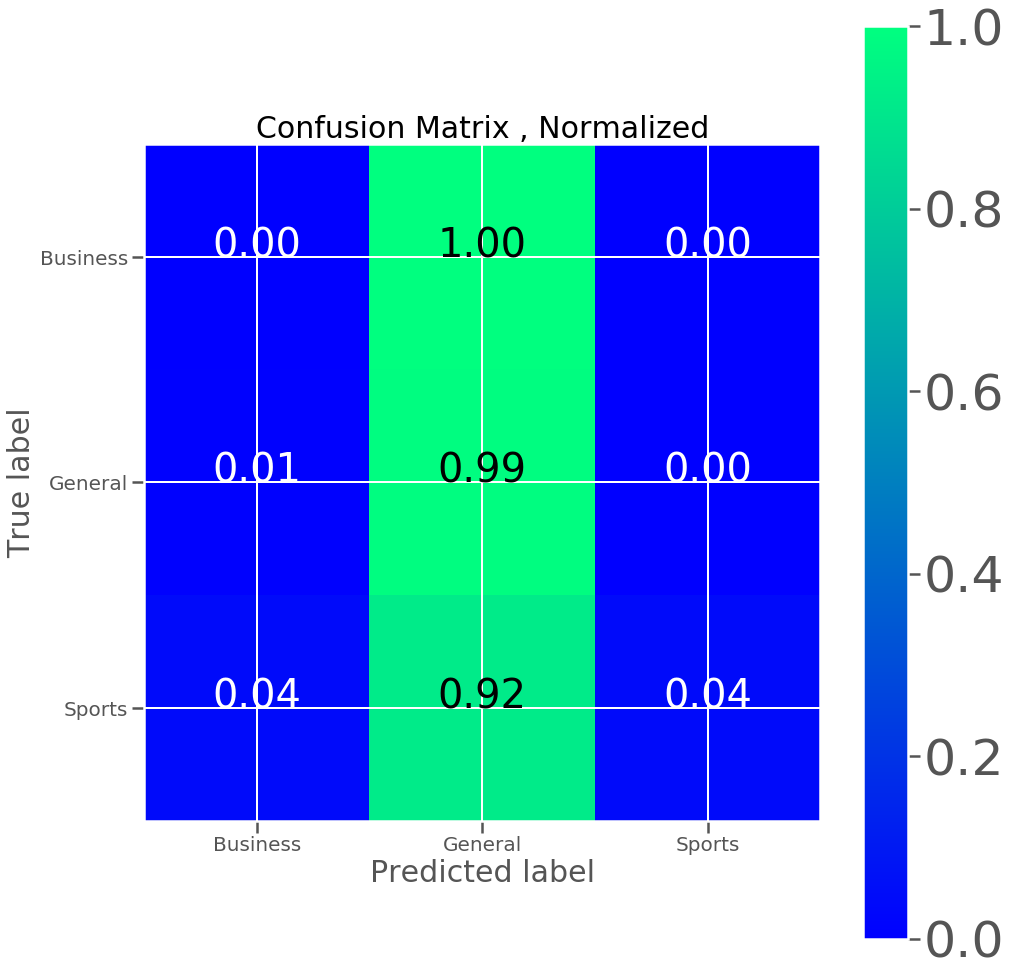

In [220]:
y_pred_cat = sgc.predict(X_test)
sns.set_context("poster", font_scale=2.3)
fig = plt.figure(figsize=(15,15))
j = plot_confusion_matrix(cm= confusion_matrix(y_test_cat, y_pred_cat), 
                      normalize    = True,
                      classes = ['Business', 'General', 'Sports'],
                      title        = "Confusion Matrix , Normalized")
j.savefig('cat_conf.png')

In [221]:
sgc.fit(df.newtitle, label2)
filename = 'cat_classifier.sav'
pickle.dump(smnc, open(filename, 'wb'))


# Hyper-Parameter tuning/model selection-Sent


In [9]:

list_labels = sent.tolist()


X_train, X_test, y_train_sent, y_test_sent = train_test_split(df.newtitle, list_labels, 
                                                    test_size=0.2,
                                                    random_state=7274)



In [10]:
#SVM hyper parameter
ssgparameters = {
     'tfidf__use_idf': (True, False),
     'clf__penalty':('l2', 'l1', 'elasticnet'),
     'vect__ngram_range': [(1, 1), (1, 2), (1,3), (1,4), (1,5)],
     'vect__max_features':(None, 5900, 5000, 4500, 4000, 3500),
     'clf__alpha': (1, 1e-2, 1e-3, 1e-4),
     'clf__max_iter':(400, 500, 800, 900, 1000, 1200, 1500)
}
ssgd_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=final_stop_words )),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=32))
    ])
ssgd = GridSearchCV(ssgd_clf, ssgparameters,verbose = 2, cv=5, n_jobs=-1, scoring='precision_weighted')


In [11]:
#Hyper parameter tuninf for random forst- first randomized search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'clf__n_estimators': n_estimators,
               'clf__max_features': max_features,
               'clf__max_depth': max_depth,
               'clf__min_samples_split': min_samples_split,
               'clf__min_samples_leaf': min_samples_leaf,
               'clf__bootstrap': bootstrap,
               'vect__ngram_range': [(1, 1), (1, 2), (1,3), (1,4), (1,5)],
               'vect__max_features':(None, 5900, 5000),
               'tfidf__use_idf': (True, False),
 }
srf_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=final_stop_words )),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=32))
    ])






In [12]:
rf_random = RandomizedSearchCV(estimator = srf_clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train_sent)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(stop_words={'a',
                                                                          'about',
                                                                          'above',
                                                                          'after',
                                                                          'again',
                                                                          'ain',
                                                                          'am',
                                                                          'an',
                                                                          'and',
                                                                          'any',
                                                                          'are',
                          

In [13]:
rf_random.best_params_

{'vect__ngram_range': (1, 1),
 'vect__max_features': None,
 'tfidf__use_idf': False,
 'clf__n_estimators': 1800,
 'clf__min_samples_split': 5,
 'clf__min_samples_leaf': 4,
 'clf__max_features': 'sqrt',
 'clf__max_depth': 110,
 'clf__bootstrap': False}

In [22]:
#Hyper parameter tuning for random forest (takes a while to run)


srfparameters = {
     'tfidf__use_idf': (True, False),
     'clf__n_estimators': (1000, 900, 800),
     'clf__min_samples_split':(4, 5, 6),
     'clf__min_samples_leaf':(3,4,5),
     'vect__ngram_range': [(1, 1)],
     'vect__max_features':([None]),
     'clf__max_features': (['sqrt']),
     'clf__max_depth':(100, 110,120 ),
     'clf__bootstrap':([False])
}
srf_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=final_stop_words )),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=32))
    ])
srf = GridSearchCV(srf_clf, srfparameters, verbose = 2, cv=5, n_jobs=-1, scoring='precision_weighted')


In [23]:
#Hyper parameter tuning for Multinomial Naive Bayes
smnbparameters = {
     'tfidf__use_idf': (True, False),
     'vect__ngram_range': [(1, 1), (1, 2), (1,3), (1,4), (1,5)],
     'vect__max_features':(None, 5900, 5000, 4500, 4000, 3500),
     'mnb__alpha': np.linspace(0.5, 1.5, 6),
     'mnb__fit_prior': [True, False],
}
smn_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=final_stop_words )),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())
    ])
smn = GridSearchCV(smn_clf, smnbparameters,verbose = 2, cv=5, n_jobs=-1, scoring='precision_weighted')


In [24]:
ssgd = ssgd.fit(X_train,y_train_sent)

Fitting 5 folds for each of 5040 candidates, totalling 25200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

In [25]:
srf = srf.fit(X_train,y_train_sent)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  7.1min finished


In [26]:
smn = smn.fit(X_train, y_train_sent)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  1.4min finished


In [27]:
ssgdc = ssgd.best_estimator_
srfc = srf.best_estimator_
smnc = smn.best_estimator_

C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

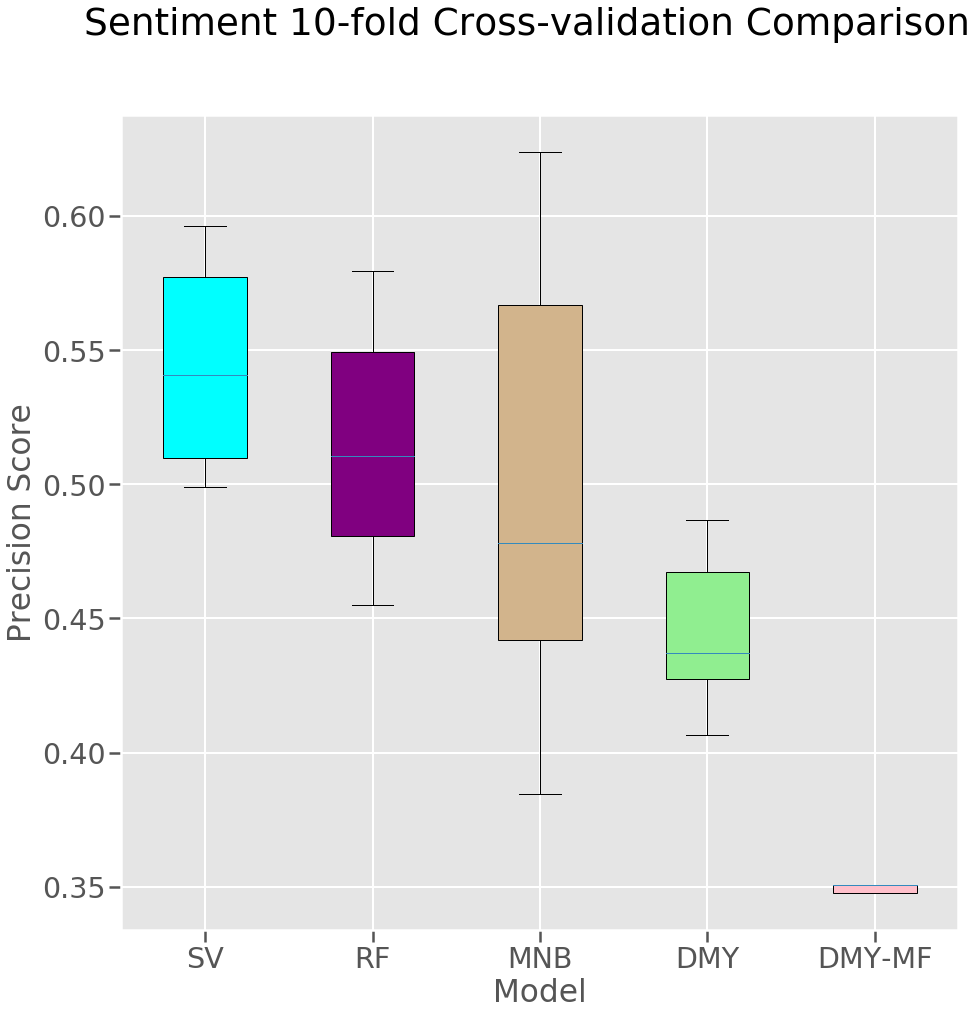

In [29]:
from sklearn import model_selection
#Dummy classifier
dummy_mf = DummyClassifier(strategy="most_frequent", random_state=231)
dummy_mf.fit(X_train, y_train_sent)
dummy = DummyClassifier(random_state=231)
dummy.fit(X_train, y_train_sent)
dummymfcv = model_selection.cross_val_score(dummy_mf,X_train,y_train_sent,
                                        scoring = 'precision_weighted',cv=10
                                         )
dummymfcv

dummycv = model_selection.cross_val_score(dummy,X_train,y_train_sent,
                                        scoring = 'precision_weighted', cv=10
                                         )
ssgcv = model_selection.cross_val_score(ssgdc,X_train,y_train_sent,
                                        scoring = 'precision_weighted',cv = 10
                                         )

srfcv = model_selection.cross_val_score(srfc,X_train,y_train_sent,
                                        scoring = 'precision_weighted', cv = 10
                                         )

smnccv = model_selection.cross_val_score(smnc,X_train,y_train_sent,
                                        scoring = 'precision_weighted', cv = 10
                                         )

results = [ssgcv, srfcv, smnccv, dummycv, dummymfcv]


plt.style.use('ggplot')

sns.set_context("poster", font_scale=1.3)
fig = plt.figure(figsize=(15,15))
fig.suptitle('Sentiment 10-fold Cross-validation Comparison')
ax = fig.add_subplot(111)
box = plt.boxplot(results, patch_artist=True)
plt.xlabel('Model')
plt.ylabel('Precision Score')
ax.set_xticklabels(['SV', 'RF',  'MNB', 'DMY', 'DMY-MF'])
colors = ['cyan','purple', 'tan', 'lightgreen', 'pink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.savefig('class_comparison_sent.png')
plt.show()

Support vector machine is the best choice

In [30]:
ssgdc

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 5),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'ain', 'am', 'an', 'and',
                                             'any', 'are', 'aren', "aren't",
                                             'as', 'at', 'be', 'because',
                                             'been', 'before', 'being', 'below',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", 'd', 'did',
                                             'didn', ...})),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', SGDClassifier(max_iter=400, random_state=32))])

In [32]:
ssgdc.fit(X_train, y_train_sent)

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 5),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'ain', 'am', 'an', 'and',
                                             'any', 'are', 'aren', "aren't",
                                             'as', 'at', 'be', 'because',
                                             'been', 'before', 'being', 'below',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", 'd', 'did',
                                             'didn', ...})),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', SGDClassifier(max_iter=400, random_state=32))])

In [33]:
pred = ssgdc.predict(X_test)


In [34]:
precision_score(y_test_sent,pred, average= 'weighted')

0.523700808388821

In [233]:
pred_proba = smnc.predict_proba(X_test)
words = np.take(count_vect.get_feature_names(), pred_proba.argmax(axis=1))

In [279]:




tf = TfidfVectorizer(max_features=3500, stop_words= final_stop_words, ngram_range=(1,3)).fit(df.newtitle)
tf.vocabulary_.__len__()  # returns 5945 as we passed 5945 words
j = tf.fit_transform(df.newtitle)  #
#count_vectorizer.fit(df.newtitle)
#count_vectorizer
# tfidf = TfidfTransformer.fit(tfidf,X=cvf)

model = MultinomialNB(alpha = 0.5, fit_prior=False)

model.fit(j,list_labels)

class_labels=model.classes_
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
class_labels


C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass input=2469    Trump launches defensive Twitter spree as Amer...
2416    Trudeau attends ant-racism rally and takes a knee
658     DC mayor inaugurates 'Black Lives Matter Plaza...
2195    Teaching for Black Lives   â€ a handbook to f...
1145    How a call to police over a $20 bill unleashed...
                              ...                        
486     Carroll Foy formally launches bid for Virginia...
1331    Joe Biden needs black voters to win the presid...
1664    News24.com | Donald Trump slams Drew Brees apo...
1698    News24.com | WATCH | Trump sparks controversy ...
1659    News24.com | Bayern Munich show support for Bl...
Name: newtitle, Length: 2284, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([0, 1, 2])

In [ ]:
#print_top10(tf, model, class_labels)
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
>>> X2 = vectorizer2.fit_transform(corpus)
>>> print(vectorizer2.get_feature_names())

In [301]:
count_vectorizer.get_feature_names()

['000',
 '10',
 '10 15',
 '10 best',
 '10 biggest',
 '100',
 '100 000',
 '100 million',
 '11',
 '12',
 '14',
 '14 trillion',
 '14 trillion reparations',
 '15',
 '16',
 '19',
 '19 could',
 '19 fight',
 '19 patients',
 '1918',
 '1968',
 '1m',
 '1st',
 '20',
 '2000',
 '2000 blackface',
 '2000 blackface skit',
 '2015',
 '2016',
 '2020',
 '2020 daily',
 '2020 daily trail',
 '2020 election',
 '2020 far',
 '25',
 '30',
 '40',
 '40 000',
 '400',
 '50',
 '50 states',
 '60',
 '74',
 '90',
 '90 000',
 '911',
 '911 call',
 'abc',
 'abc news',
 'abdul',
 'abdul jabbar',
 'able',
 'abrams',
 'absentee',
 'abuse',
 'access',
 'according',
 'accounts',
 'accused',
 'accuses',
 'accuses trump',
 'aclu',
 'across',
 'across america',
 'across country',
 'across united',
 'across united states',
 'across us',
 'act',
 'action',
 'action police',
 'actions',
 'actions against',
 'activism',
 'activist',
 'activists',
 'actor',
 'actor john',
 'actor john boyega',
 'ad',
 'address',
 'addresses',
 'address

In [336]:

count_vect = CountVectorizer(stop_words=final_stop_words,ngram_range=(1,3),
                            max_features = 3500)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape
count_vect.vocabulary_.get(u'algorithm')
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

model = MultinomialNB(alpha = 0.5, fit_prior=False)

model.fit(X_train_tf,y_train_sent)


MultinomialNB(alpha=0.5, fit_prior=False)

In [ ]:

class_labels=model.classes_
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        #print(clf.coef_)
        print("%s:| %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
print_top10(count_vect, model,class_labels )

In [300]:
#Get indeces of top predicted words
neg_class_prob_sorted = smnc[2].feature_log_prob_[0, :].argsort()
neut_class_prob_sorted = smnc[2].feature_log_prob_[1, :].argsort()
pos_class_prob_sorted = smnc[2].feature_log_prob_[2, :].argsort()
#trusty count_vectorizer
count_vectorizer = CountVectorizer(max_features=3500, ngram_range=(1,3),
                       stop_words=final_stop_words)
count_vectorizer.fit_transform(X_train)
print('Negative:',np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print('Positive:',np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))
print('Neutral:',np.take(count_vect.get_feature_names(), neut_class_prob_sorted[:10]))

def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
































Negative: ['electoral' 'endorsements' 'endemic' 'encouraged' 'encourage' 'enabler'
 'employment' 'employers' 'emotionally' 'emotional']
Positive: ['deleted' 'lin' 'backstory' 'meaningful' 'conservatives' 'consider'
 'duvernay' 'humanity' 'deserves' 'julian']
Neutral: ['congregations' 'different' 'difficult' 'digital' 'digits' 'issued'
 'issue' 'difference' 'diplomats' 'director']


In [54]:
sent_model = pickle.load(open('sent_classifier.sav', 'rb'))

smnbparameters = {
     'tfidf__use_idf': [(True)],
     'vect__ngram_range': [(1,3)],
     'vect__max_features':[(5900)],
     'mnb__alpha':[ 0.5],
     'mnb__fit_prior': [False],
}
smn_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=final_stop_words )),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())
    ])

In [55]:
smn_clf.fit(X_train, y_train_sent)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'ain', 'am', 'an', 'and',
                                             'any', 'are', 'aren', "aren't",
                                             'as', 'at', 'be', 'because',
                                             'been', 'before', 'being', 'below',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", 'd', 'did',
                                             'didn', ...})),
                ('tfidf', TfidfTransformer()), ('mnb', MultinomialNB())])

In [56]:
from sklearn.metrics import confusion_matrix
y_pred = smn_clf.predict(X_test)


In [58]:
precision_score(y_test_sent, y_pred, average = 'weighted')



C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4867371896783662

In [19]:
y_test_sent

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 2,


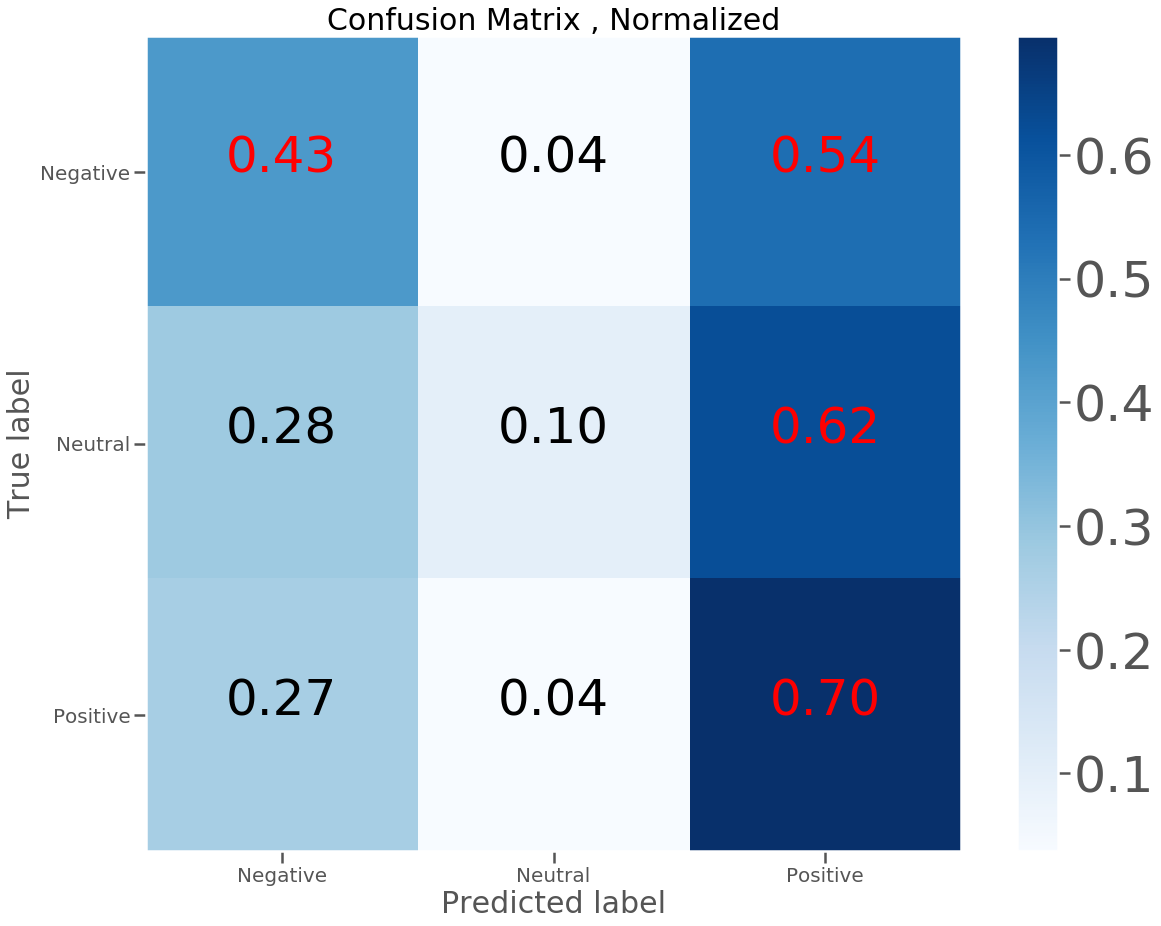

In [53]:

sns.set_context("poster", font_scale=2.3)
fig = plt.figure(figsize=(20,15))
j = plot_confusion_matrix(cm= confusion_matrix(y_test_sent, pred), 
                      normalize    = True,
                      classes = ['Negative', 'Neutral', 'Positive'],
                      title        = "Confusion Matrix , Normalized")
j.savefig('test.png')

In [179]:
filename = 'ssgdc.sav'
pickle.dump(ssgdc, open(filename, 'wb'))
filename = 'srfc.sav'
pickle.dump(srfc, open(filename, 'wb'))


In [76]:
ssgd = pickle.load(open('ssgdc.sav', 'rb'))


In [77]:
ssgd

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 4),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'ain', 'am', 'an', 'and',
                                             'any', 'are', 'aren', "aren't",
                                             'as', 'at', 'be', 'because',
                                             'been', 'before', 'being', 'below',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", 'd', 'did',
                                             'didn', ...})),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', SGDClassifier(max_iter=400, random_state=32))])

In [ ]:
smnc #what are you focused on

In [54]:
ssgdc.fit(df.newtitle, list_labels)
filename = 'sent_classifier.sav'
pickle.dump(ssgdc, open(filename, 'wb'))


#smnc.predict(pd.Series("Death spreads"))

In [133]:

bm = smnc[2]

In [140]:
class_labels

array([0, 1, 2])

In [142]:

class_labels=bm.classes_
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
print_top10(tf, bm, ['Negative', 'Neutral', 'Positive'])



Negative: be more us protests denying gunfire gunned police will frey quell protests trial biden comments
Neutral: denying lack of be more quell protests gunned gunfire frey us protests trial criminal
Positive: police will from atlanta denying be more quell protests trial biden comments gunned gunfire frey


In [44]:
ssgcv.std(), srfcv.std(), smnccv.std()

(0.004659113003726461, 0.006905641618933873, 0.01830374227811902)

In [52]:
sdummymfcv.mean(), sdummymfcv.std()

(0.5910710181567456, 0.0012666862609197796)

C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

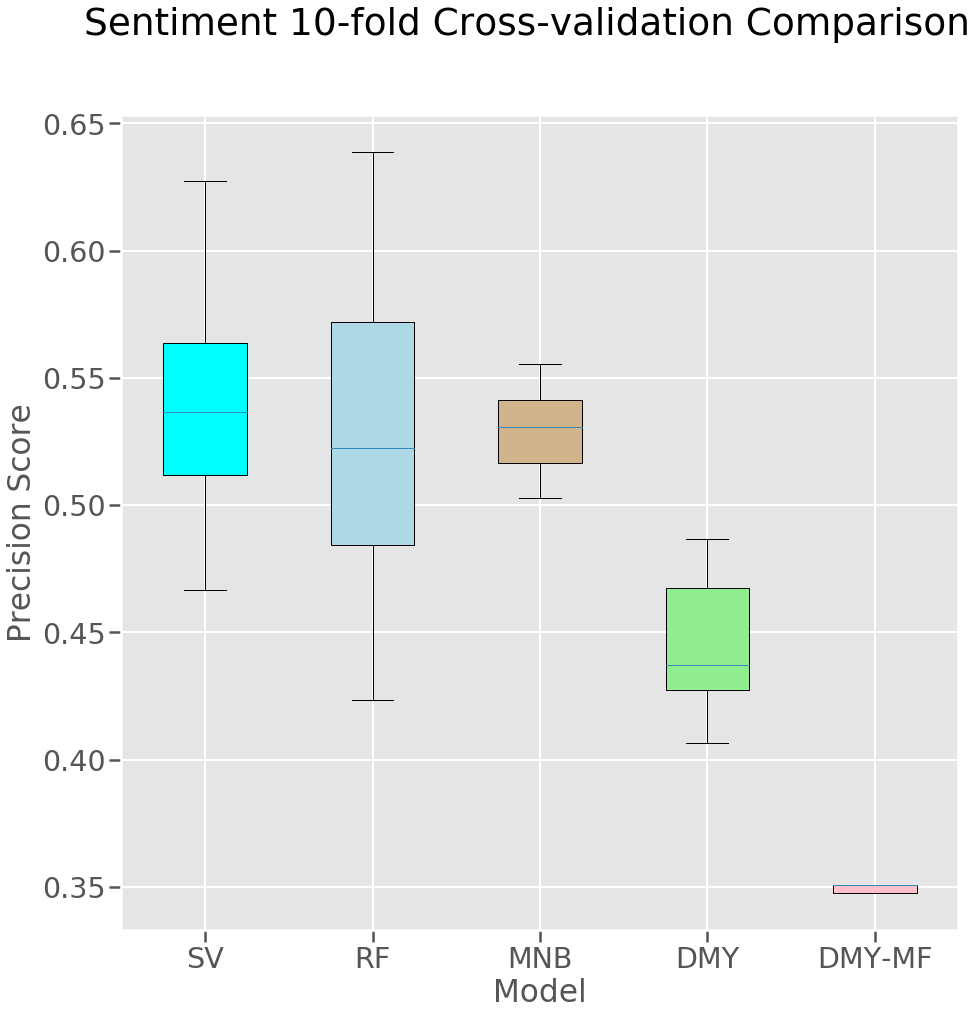

# NN Category

In [ ]:
X_train, X_test, y_train_cat, y_test_cat = train_test_split(list_corpus, label2, 
                                                    test_size=0.2,
                                                    random_state=7274)
X_traindf = pd.DataFrame({'x': X_train})



In [173]:
#First trying DistilBERT
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
tokenized = X_traindf['x'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\camer/.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json from cache at C:\Users\camer/.cache\torch\transformers\a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_la

In [174]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [175]:
attention_mask = np.where(np.array(padded)!=0,1,0)

attention_mask.shape
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
input_ids = input_ids.clone().detach().to(torch.int64)

In [176]:

#input_ids = torch.tensor(input_ids).to(torch.int64)

with torch.no_grad():
    print('...')
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
x_train_features = last_hidden_states[0][:,0,:].numpy()



...


KeyboardInterrupt: 

In [ ]:
#Random forest randomized cv
from sklearn.model_selection import RandomizedSearchCV
#n_estimators = max trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
#Max_features = max # of features considered at each split
max_features = ['auto', 'sqrt']
#max_depth = max #of levels in each decision tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 8)]
max_depth.append(None)
#Min_samples_split = min number of data points placed in a ndoe before node is split
min_samples_split = [2, 5, 10]
#min_samples_leaf= min number of data ponits allowed in a leaf node
min_samples_leaf = [1, 2, 4]
#bootstrap = method for sampling data points (with or without replacement)
bootstrap = [True,False]

random_grid = {'n_estimators' : n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}



In [ ]:
rf_bert = RandomForestClassifier()


#Random search of parameters using 3 fold cross validation, seaerch across 100 different combinations
#Use all cores

rf_bert = RandomizedSearchCV(estimator = rf_bert, param_distributions= random_grid,
                              n_iter=100, cv = 3, verbose = 2, random_state=1984,
                              n_jobs = -1 , scoring = 'precision_weighted' )


In [ ]:
rf_bert.fit(x_train_features, y_train_cat)

In [76]:
param_grid = {'n_estimators': [550, 575, 600, 625, 650],
 'min_samples_split': [1, 2, 3],
 'min_samples_leaf': [3, 4, 5],
 'max_features': ['auto'],
 'max_depth': [19,20,21,22,23],
 'bootstrap': [False]}
#rf_bert.best_params_

In [77]:
# Create a based model
rf_bert = RandomForestClassifier()
# Instantiate the grid search model
rf_bert_grid = GridSearchCV(estimator = rf_bert, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2 , scoring = 'precision_weighted')

In [78]:
rf_bert_grid.fit(x_train_features, y_train_cat)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 52.1min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [19, 20, 21, 22, 23],
                         'max_features': ['auto'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [550, 575, 600, 625, 650]},
             scoring='precision_micro', verbose=2)

In [79]:
rf_bert = rf_bert_grid.best_estimator_
# rf_bert.get_params()
# {'bootstrap': False,
#  'ccp_alpha': 0.0,
#  'class_weight': None,
#  'criterion': 'gini',
#  'max_depth': 19,
#  'max_features': 'auto',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_impurity_split': None,
#  'min_samples_leaf': 3,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 550,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': None,
#  'verbose': 0,
#  'warm_start': False}

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 19,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 550,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [80]:
#Logistic regression

lg = LogisticRegression()

penalties = ['l1', 'l2', 'elasticnet']
C_range = [0.001, 0.01, 0.1, 1, 10, 100]
iters = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
random_grid = {'penalty' : penalties,
              'C': C_range,
              'max_iter': iters
              }
lgrandomized = RandomizedSearchCV(estimator = lg, param_distributions= random_grid,
                              n_iter=100, cv = 3, verbose = 2, random_state=1984,
                              n_jobs = -1 , scoring = 'precision_weighted' )
lgrandomized.fit(x_train_features, y_train_cat)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   45.6s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'max_iter': [200, 400, 600, 800, 1000],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   random_state=1984, scoring='precision_micro', verbose=2)

In [83]:
param_grid = {'penalty': ['l2'], 'max_iter': [125, 150, 175, 200, 225, 250], 
              'C':[0.002, 0.003, 0.001]}

#lgrandomized.best_params_

In [86]:
# Create a based model
lg_bert = LogisticRegression()
# Instantiate the grid search model
lg_bert_grid = GridSearchCV(estimator = lg_bert, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2 , scoring = 'precision_weighted')

In [87]:
lg_bert_grid.fit(x_train_features, y_train_cat)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    6.3s finished


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.002, 0.003, 0.001],
                         'max_iter': [125, 150, 175, 200, 225, 250],
                         'penalty': ['l2']},
             scoring='precision_micro', verbose=2)

In [89]:
lg_bert = lg_bert_grid.best_estimator_
# lg_bert.get_params()
# {'C': 0.002,
#  'class_weight': None,
#  'dual': False,
#  'fit_intercept': True,
#  'intercept_scaling': 1,
#  'l1_ratio': None,
#  'max_iter': 125,
#  'multi_class': 'auto',
#  'n_jobs': None,
#  'penalty': 'l2',
#  'random_state': None,
#  'solver': 'lbfgs',
#  'tol': 0.0001,
#  'verbose': 0,
#  'warm_start': False}



{'C': 0.002,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 125,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [103]:
logbertcv = model_selection.cross_val_score(lg_bert,x_train_features,y_train_cat,
                                        scoring = 'precision_weighted',cv = 10
                                         )
logbertcv

rfbertcv = model_selection.cross_val_score(rf_bert,x_train_features,y_train_cat,
                                        scoring = 'precision_weighted', cv = 10
                                         )
rfbertcv

array([0.94323144, 0.94323144, 0.93449782, 0.93886463, 0.94298246,
       0.94298246, 0.94298246, 0.94298246, 0.94298246, 0.94298246])

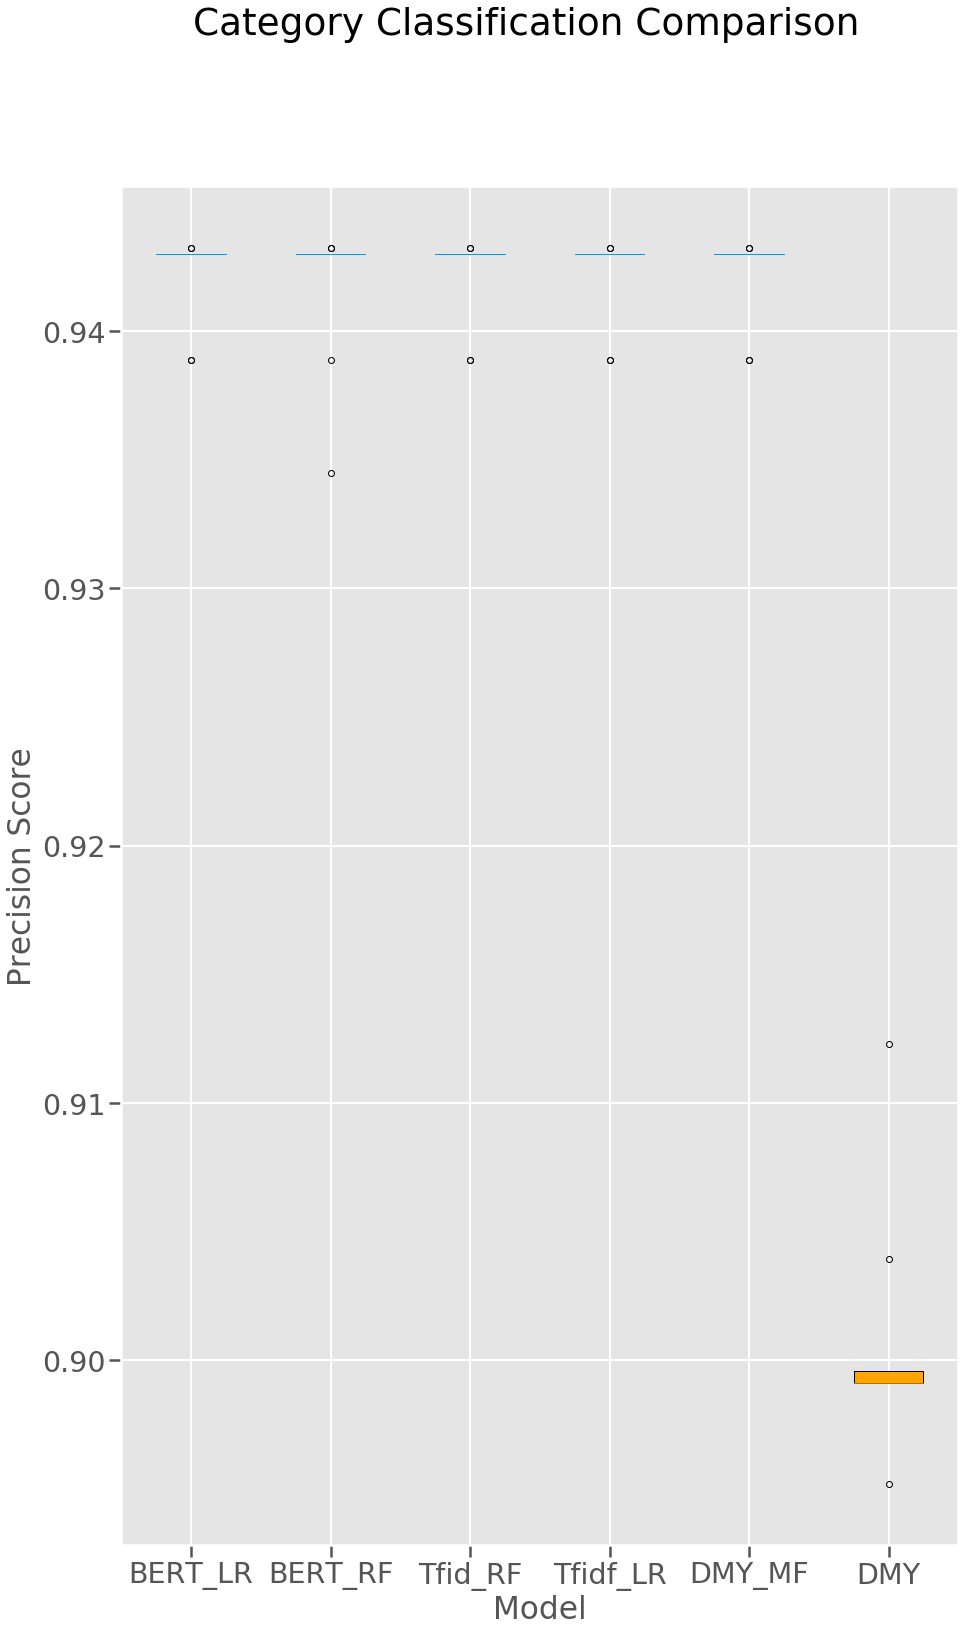

In [123]:
results = [logbertcv, rfbertcv, rftfcv, logtfcv, dummymfcv, dummycv]


plt.style.use('ggplot')

sns.set_context("poster", font_scale=1.3)
fig = plt.figure(figsize=(15,25))
fig.suptitle('Category Classification Comparison')
ax = fig.add_subplot(111)
box = plt.boxplot(results, patch_artist=True)
plt.xlabel('Model')
plt.ylabel('Precision Score')
ax.set_xticklabels(['BERT_LR', 'BERT_RF', 'Tfid_RF', 'Tfidf_LR', 'DMY_MF', 'DMY'])
colors = ['cyan', 'lightblue', 'tan', 'purple', 'lightgreen', 'orange']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.savefig('class_comparison_cat.png')
plt.show()


In [ ]:


list_labels = sent.tolist()
X_train, X_test, y_train_sent, y_test_sent = train_test_split(list_corpus, list_labels, 
                                                    test_size=0.2,
                                                    random_state=7274)
X_train, tfidf_vectorizer = tfidf(X_train)
X_test = tfidf_vectorizer.transform(X_test)


In [ ]:
# Random forest Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV
#n_estimators = max trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
#Max_features = max # of features considered at each split
max_features = ['auto', 'sqrt']
#max_depth = max #of levels in each decision tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 8)]
max_depth.append(None)
#Min_samples_split = min number of data points placed in a ndoe before node is split
min_samples_split = [2, 5, 10]
#min_samples_leaf= min number of data ponits allowed in a leaf node
min_samples_leaf = [1, 2, 4]
#bootstrap = method for sampling data points (with or without replacement)
bootstrap = [True,False]

random_grid = {'n_estimators' : n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

#Use random grid to search for best parameters
srf_tfidf = RandomForestClassifier()


#Random search of parameters using 3 fold cross validation, seaerch across 100 different combinations
#Use all cores

srf_tfidf = RandomizedSearchCV(estimator = srf_tfidf, param_distributions= random_grid,
                              n_iter=100, cv = 3, verbose = 2, random_state=1984,
                              n_jobs = -1 , scoring = 'f1_micro' )
srf_tfidf.fit(X_train, y_train_sent)


In [ ]:
srf_tfidf.best_params_

In [153]:

param_grid = {'n_estimators': [350, 375, 400, 425, 450],
 'min_samples_split': [8, 9, 10, 11, 12],
 'min_samples_leaf': [1, 2, 3],
 'max_features': ['sqrt'],
 'max_depth': [42,43,44,45,46],
 'bootstrap': [True]}


In [154]:
#Grid search RF 
from sklearn.model_selection import GridSearchCV

# Create a based model
srf_tfidf = RandomForestClassifier()
# Instantiate the grid search model
srf_tfidf_grid = GridSearchCV(estimator = srf_tfidf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2 , scoring = 'f1_micro')

In [155]:
srf_tfidf_grid.fit(X_train, y_train_sent)

Fitting 3 folds for each of 375 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 12.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [42, 43, 44, 45, 46],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [8, 9, 10, 11, 12],
                         'n_estimators': [350, 375, 400, 425, 450]},
             scoring='f1_micro', verbose=2)

In [156]:
srf_tfidf= srf_tfidf_grid.best_estimator_
# rf_tfidf.get_params()
# {'bootstrap': True,
#  'ccp_alpha': 0.0,
#  'class_weight': None,
#  'criterion': 'gini',
#  'max_depth': 45,
#  'max_features': 'sqrt',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_impurity_split': None,
#  'min_samples_leaf': 1,
#  'min_samples_split': 11,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 350,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': None,
#  'verbose': 0,
#  'warm_start': False}

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 45,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 11,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Logistic regression

slg = LogisticRegression()

penalties = ['l1', 'l2', 'elasticnet']
C_range = [0.001, 0.01, 0.1, 1, 10, 100]
iters = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
random_grid = {'penalty' : penalties,
              'C': C_range,
              'max_iter': iters
              }


In [ ]:
slgrandomized = RandomizedSearchCV(estimator = slg, param_distributions= random_grid,
                              n_iter=100, cv = 3, verbose = 2, random_state=1984,
                              n_jobs = -1 , scoring = 'f1_micro' )
slgrandomized.fit(X_train, y_train_sent)

In [ ]:
slgrandomized.best_params_
# param_grid = {'penalty': ['l2'], 'max_iter': [150, 175, 200, 225, 250],
#               'C': [0.001,0.002, 0.003 ]}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create a based model
slg_tfidf = LogisticRegression()
# Instantiate the grid search model
slg_tfidf_grid = GridSearchCV(estimator = slg_tfidf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2 , scoring = 'f1_micro')

In [ ]:
slg_tfidf_grid.fit(X_train, y_train_sent)

In [163]:
slg_tfidf = lg_tfidf_grid.best_estimator_
lg_tfidf.get_params()
# {'C': 0.001,
#  'class_weight': None,
#  'dual': False,
#  'fit_intercept': True,
#  'intercept_scaling': 1,
#  'l1_ratio': None,
#  'max_iter': 150,
#  'multi_class': 'auto',
#  'n_jobs': None,
#  'penalty': 'l2',
#  'random_state': None,
#  'solver': 'lbfgs',
#  'tol': 0.0001,
#  'verbose': 0,
#  'warm_start': False}


{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 150,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [152]:
#Cross evaluation compare
from sklearn import model_selection
slogtfcv = model_selection.cross_val_score(slg_tfidf,X_train,y_train_sent,
                                        scoring = 'f1_micro',cv=10
                                         )
slogtfcv

srftfcv = model_selection.cross_val_score(srf_tfidf,X_train,y_train_sent,
                                        scoring = 'f1_micro', cv=10
                                         )
srftfcv

array([0.60262009, 0.57641921, 0.59388646, 0.59825328, 0.60526316,
       0.56140351, 0.60526316, 0.59210526, 0.60087719, 0.59649123])

In [45]:
sdummy_mf = DummyClassifier(strategy="most_frequent", random_state=231)
sdummy_mf.fit(X_train, y_train_sent)
sdummy = DummyClassifier(random_state=231)
sdummy.fit(X_train, y_train_sent)

C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


DummyClassifier(random_state=231)

In [102]:
dpred = sdummy_mf.predict(X_test)
f1_score(y_test_sent, dpred, average = 'micro')

0.40559440559440557

In [50]:
#dumm cross eval
sdummymfcv = model_selection.cross_val_score(sdummy_mf,X_train,y_train_sent,
                                        scoring = 'f1_micro',cv=10
                                         )
sdummymfcv

sdummycv = model_selection.cross_val_score(sdummy,X_train,y_train_sent,
                                        scoring = 'f1_micro', cv=10
                                         )
sdummycv

C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


array([0.48034934, 0.43668122, 0.49344978, 0.44104803, 0.44736842,
       0.41666667, 0.42982456, 0.44736842, 0.49561404, 0.46491228])

# NN Sent

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#n_estimators = max trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
#Max_features = max # of features considered at each split
max_features = ['auto', 'sqrt']
#max_depth = max #of levels in each decision tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 8)]
max_depth.append(None)
#Min_samples_split = min number of data points placed in a ndoe before node is split
min_samples_split = [2, 5, 10]
#min_samples_leaf= min number of data ponits allowed in a leaf node
min_samples_leaf = [1, 2, 4]
#bootstrap = method for sampling data points (with or without replacement)
bootstrap = [True,False]

random_grid = {'n_estimators' : n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}



rf_bert = RandomForestClassifier()


#Random search of parameters using 3 fold cross validation, seaerch across 100 different combinations
#Use all cores

rf_bert = RandomizedSearchCV(estimator = rf_bert, param_distributions= random_grid,
                              n_iter=100, cv = 3, verbose = 2, random_state=1984,
                              n_jobs = -1 , scoring = 'precision_weighted' )


rf_bert.fit(x_train_features, y_train_sent)


In [ ]:
#Random forest randomized cv

# param_grid = {'n_estimators': [150, 175, 200, 225, 250],
#  'min_samples_split': [3, 4,5, 6, 7],
#  'min_samples_leaf': [1,2,3],
#  'max_features': ['auto'],
#  'max_depth': [53,54,55,56,57],
#  'bootstrap': [True]} 
rf_bert.best_params_

ABOVE^

In [ ]:


# Create a based model
rf_bert = RandomForestClassifier()
# Instantiate the grid search model
rf_bert_grid = GridSearchCV(estimator = rf_bert, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2 , scoring = 'precision_weighted')

rf_bert_grid.fit(x_train_features, y_train_sent)

rf_bert = rf_bert_grid.best_estimator_

rf_bert.get_params()

In [160]:
#Logistic regression

lg = LogisticRegression()

penalties = ['l1', 'l2', 'elasticnet']
C_range = [0.001, 0.01, 0.1, 1, 10, 100]
iters = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
random_grid = {'penalty' : penalties,
              'C': C_range,
              'max_iter': iters
              }
lgrandomized = RandomizedSearchCV(estimator = lg, param_distributions= random_grid,
                              n_iter=100, cv = 3, verbose = 2, random_state=1984,
                              n_jobs = -1 , scoring = 'f1_micro' )
lgrandomized.fit(x_train_features, y_train_cat)




Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\camer\anaconda3\envs\insight\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   46.4s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'max_iter': [200, 400, 600, 800, 1000],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   random_state=1984, scoring='precision_micro', verbose=2)

In [166]:
param_grid ={'penalty': ['l2'], 'max_iter': [150,175,200,20025,250], 
             'C': [0.001,0.002, 0.003]}
#lgrandomized.best_params_

In [167]:


# Create a based model
lg_bert = LogisticRegression()
# Instantiate the grid search model
lg_bert_grid = GridSearchCV(estimator = lg_bert, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2 , scoring = 'f1_micro')

lg_bert_grid.fit(x_train_features, y_train_sent)

lg_bert = lg_bert_grid.best_estimator_

lg_bert.get_params()


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.8s finished


{'C': 0.003,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 150,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [145]:


# logbertcv = model_selection.cross_val_score(lg_bert,x_train_features,y_train_sent,
#                                         scoring = 'f1_micro',cv = 10
#                                          )
# logbertcv

rfbertcv = model_selection.cross_val_score(rf_bert,x_train_features,y_train_sent,
                                        scoring = 'f1_micro', cv = 10
                                         )
rfbertcv


NameError: name 'rf_bert' is not defined

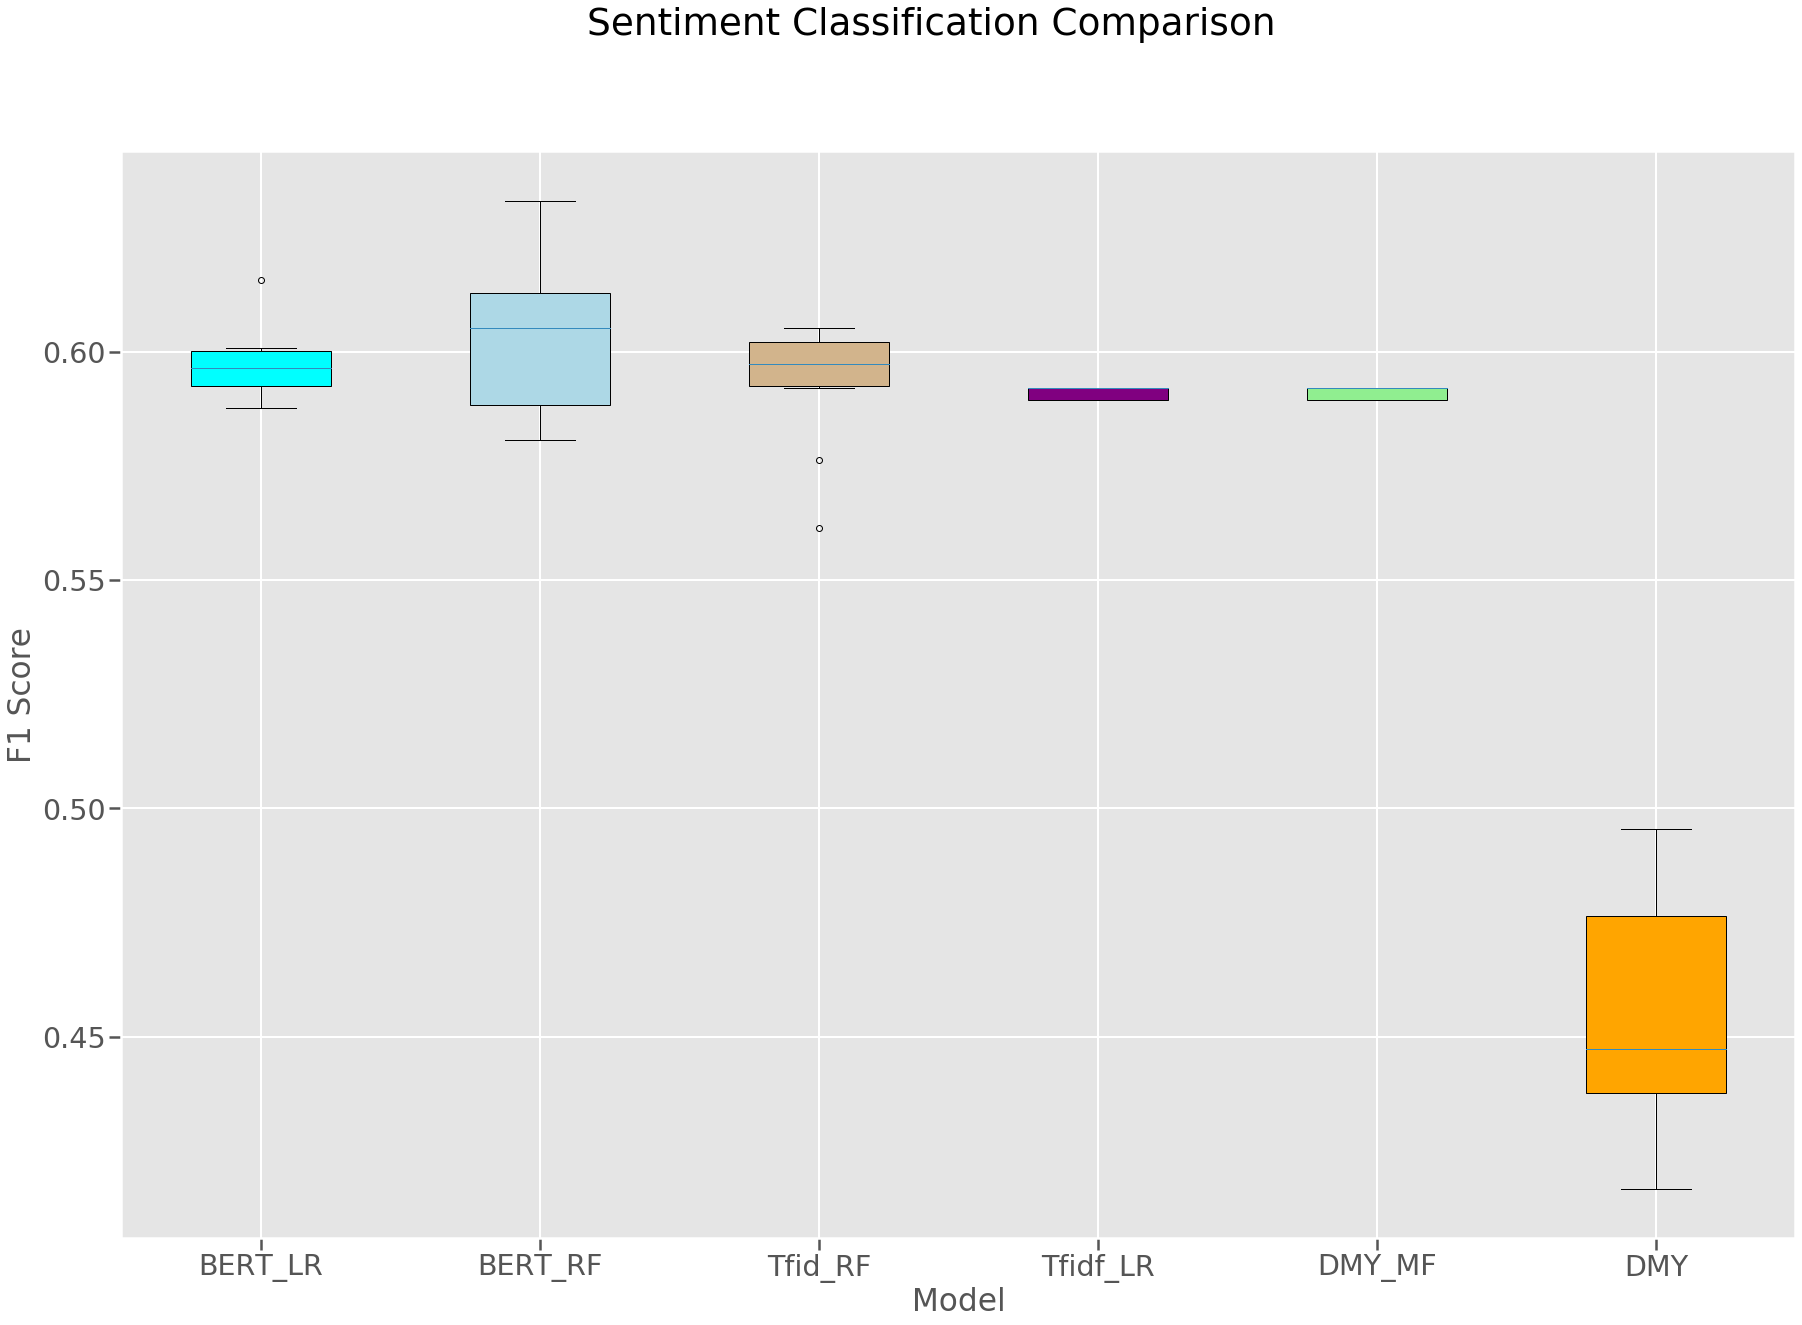

In [172]:

results = [logbertcv, rfbertcv, ssgcv, srfcv, smnccv, dummycv, dummymfcv]]


plt.style.use('ggplot')

sns.set_context("poster", font_scale=1.3)
fig = plt.figure(figsize=(30,20))
fig.suptitle('Sentiment 10-fold CV Comparison')
ax = fig.add_subplot(111)
box = plt.boxplot(results, patch_artist=True)
plt.xlabel('Model')
plt.ylabel('F1 Score')
ax.set_xticklabels(['BERT_LR', 'BERT_RF', 'Tfid_SVM', 'Tfidf_RF', 'Tfidf_MNB',
                    'DMY', 'DMY_MF'])
colors = ['orange','grey', 'cyan', 'lightblue', 'tan', 'purple', 'lightgreen', 'pink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.savefig('class__bert_comparison_sent.png')
plt.show()